# Automated CRM Tagging & Propensity Engine
### Algorithmic Classification of Customer Lifecycle Stages
.
**Introduction**
Manual CRM segmentation is often inconsistent and unscalable, leading to poor pipeline visibility. This project implements a **Multi-class XGBoost Propensity Engine** to automate the classification of accounts into five lifecycle stages: *Target, Prospect, Client, Free Account,* and *Deactivated*. By leveraging firmographic features (Revenue, Employees, Location, Industry), this model replaces subjective manual tagging with an objective, algorithmic standard.

**Objectives**
* **Automated Data Hygiene:** Eliminate manual tagging overhead and ensure real-time CRM accuracy.
* **Pipeline Integrity:** Strictly distinguish qualified *Prospects* from low-value *Free Accounts* to remove pipeline bloat.
* **Predictive Prioritization:** Direct sales efforts toward accounts with the highest propensity for conversion (*Target* class).
* **Churn Detection:** Identify active accounts exhibiting forensic patterns similar to *Deactivated* users for proactive retention.


# Modeling and Results

---

## Objective
Develop and compare advanced gradient boosting models for multi-class classification to maximize predictive accuracy and interpretability.

---

## Models Used
- **LightGBM**
  - Chosen for speed and efficiency on large datasets.
  - Handles categorical features and supports multi-class objectives.
- **XGBoost**
  - Selected for its robust regularization and proven performance in structured data tasks.
- **CatBoost**
  - Preferred for native handling of categorical variables and reduced need for extensive preprocessing.

---

## Hyperparameter Strategy
- Applied **early stopping** to prevent overfitting.
- Tuned key parameters:
  - `learning_rate` (0.03–0.05) for gradual convergence.
  - `max_depth` (6) for balanced complexity.
  - `subsample` and `colsample_bytree` (0.8) for variance reduction.
  - Regularization (`lambda`, `alpha`) for stability.
- Iterations capped at 500–1000 with early stopping rounds (50).

---

## Evaluation Metrics
- **Accuracy** and **Macro F1 Score** for overall and class-balanced performance.
- **Classification Report** for precision, recall, and F1 per class.
- **Confusion Matrix** for misclassification patterns.
- **Feature Importance** for interpretability.

---

## Results Summary
| Model      | Accuracy | Macro F1 |
|------------|----------|----------|
| LightGBM   | 81.30%   | 0.4939   |
| XGBoost    | 81.38%   | 0.4914   |
| CatBoost   | 81.31%   | 0.4859   |

**Key Insights:**
- All models perform similarly (~81% accuracy).
- Strong performance for majority classes (*Free Account*, *Deactivated*).
- Minority classes (*Client*, *Prospect*) remain challenging.
- Top predictive features: Country, `log_revenue`, `log_num_employees`.

---


### Feature Matrix Ingestion & Validation
Retrieves the serialized feature matrix (`X`) and target vector (`y`) from persistent storage (Parquet), verifying dimensionality to ensure data integrity prior to model initialization.

In [1]:
import pandas as pd
import numpy as np

# 1. Load the processed X and y
X = pd.read_parquet('processed_data/X_processed.parquet')
y = pd.read_parquet('processed_data/y_encoded.parquet')['target']

# 2. Verify shapes
print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (42538, 36)
y Shape: (42538,)


In [3]:
import joblib

# Load the artifacts saved from the Feature Engineering notebook
le = joblib.load('artifacts/label_encoder.joblib')
# You likely need feature_names too for step 8
# If you didn't save it, you can assume X.columns has the names if X is a DataFrame
feature_names = X.columns.tolist() 

print(f"✅ Loaded LabelEncoder classes: {le.classes_}")

✅ Loaded LabelEncoder classes: ['Client' 'Deactivated' 'Free Account' 'Prospect' 'Target']


0:	learn: 1.5430946	test: 1.5436901	best: 1.5436901 (0)	total: 8.28ms	remaining: 8.27s
100:	learn: 0.5988318	test: 0.6111470	best: 0.6111470 (100)	total: 481ms	remaining: 4.28s
200:	learn: 0.5529442	test: 0.5675006	best: 0.5675006 (200)	total: 919ms	remaining: 3.65s
300:	learn: 0.5342372	test: 0.5513767	best: 0.5513767 (300)	total: 1.38s	remaining: 3.19s
400:	learn: 0.5210638	test: 0.5412298	best: 0.5412298 (400)	total: 1.82s	remaining: 2.71s
500:	learn: 0.5126581	test: 0.5359118	best: 0.5359118 (500)	total: 2.26s	remaining: 2.25s
600:	learn: 0.5062631	test: 0.5329192	best: 0.5329192 (600)	total: 2.69s	remaining: 1.79s
700:	learn: 0.5008472	test: 0.5305791	best: 0.5305775 (699)	total: 3.16s	remaining: 1.35s
800:	learn: 0.4961959	test: 0.5291222	best: 0.5291153 (799)	total: 3.6s	remaining: 894ms
900:	learn: 0.4921412	test: 0.5280560	best: 0.5280560 (900)	total: 4.04s	remaining: 444ms
999:	learn: 0.4884804	test: 0.5273619	best: 0.5273585 (997)	total: 4.47s	remaining: 0us

bestTest = 0.52

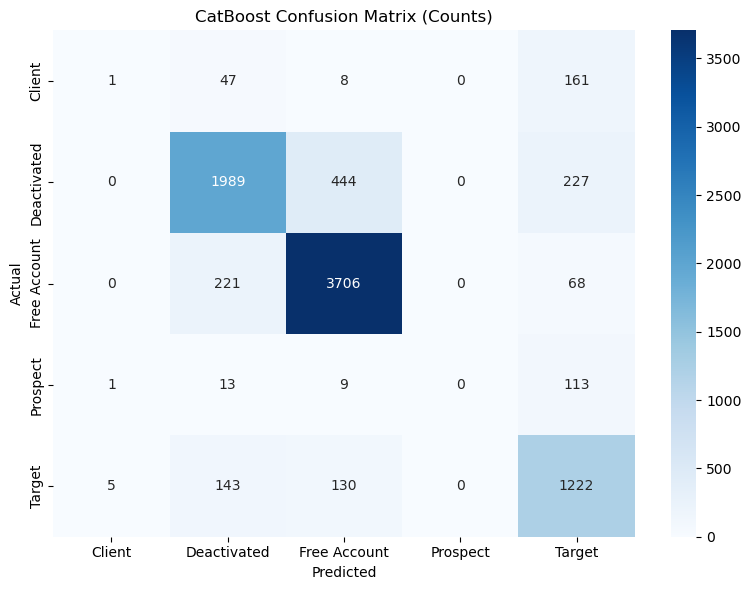

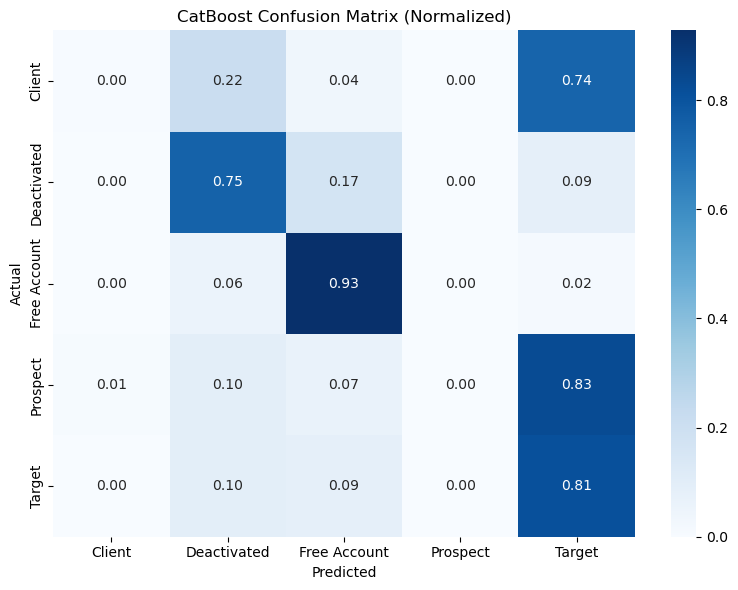

/var/folders/5p/rhydj6vd2mn7d_v158mxm0zc0000gn/T/ipykernel_38420/3033832829.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette='Blues_r')


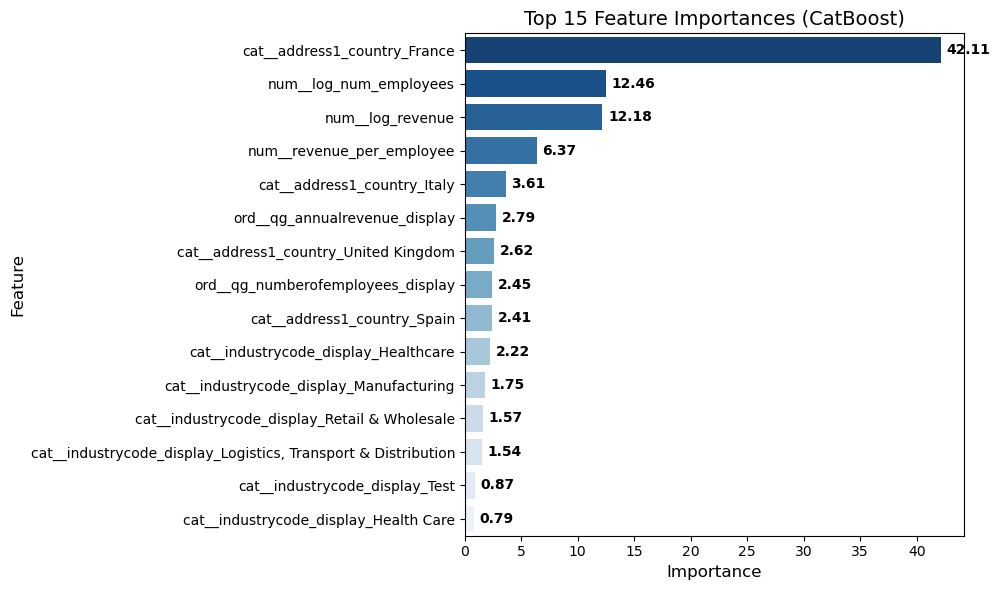

In [4]:



from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -------- 1) Train-Test Split --------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------- 2) Define CatBoost Model --------
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    loss_function='MultiClass',
    eval_metric='MultiClass',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50
)

# -------- 3) Train Model --------
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test))

# -------- 4) Predictions --------
y_pred = cat_model.predict(X_test)
y_pred = y_pred.flatten()  # CatBoost returns 2D array

# -------- 5) Evaluation --------
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
print("\n✅ CatBoost Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# -------- 6) Confusion Matrix Visualization --------
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
class_names = le.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("CatBoost Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("CatBoost Confusion Matrix (Normalized)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# -------- 7) Feature Importance Visualization --------
feature_importances = cat_model.get_feature_importance()
sorted_idx = np.argsort(feature_importances)[::-1][:15]
top_features = [feature_names[i] for i in sorted_idx]
top_importances = feature_importances[sorted_idx]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features, palette='Blues_r')
plt.title("Top 15 Feature Importances (CatBoost)", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
for i, v in enumerate(top_importances):
    plt.text(v + 0.5, i, f"{v:.2f}", va='center', fontweight='bold')
plt.tight_layout()
plt.show()




## CatBoost Model Summary
- **Accuracy:** 81.31%
- **Macro F1 Score:** 0.4859
- **Strengths:**
  - Performs well on majority classes:
    - *Free Account*: Precision 0.86, Recall 0.93
    - *Deactivated*: F1 ≈ 0.78
    - *Target*: Recall 0.81
- **Weaknesses:**
  - *Client* and *Prospect* classes have near-zero recall and precision.
- **Confusion Matrix Insights:**
  - Heavy concentration on Free Account and Deactivated predictions.
  - Minority classes are overshadowed.
- **Top Features Driving Predictions:**
  - Country (France, Italy, UK, Spain)
  - `log_num_employees`, `log_revenue`
  - Revenue per employee and annual revenue bands
- **Business Implication:**
  - Reliable for predicting Free Account and Deactivated.
  - Needs improvement for Client and Prospect.



## Comparison of All Three Models
| Model      | Accuracy | Macro F1 |
|------------|----------|----------|
| LightGBM   | 81.30%   | 0.4939   |
| XGBoost    | 81.38%   | 0.4914   |
| CatBoost   | 81.31%   | 0.4859   |

**Observations:**
- All models perform similarly on overall metrics.
- None significantly outperform the others.
- All struggle with minority classes (Client & Prospect).
- Feature importance patterns are consistent: country and revenue-related features dominate.



## Recommendations & Next Steps
1. **Address Class Imbalance:**
   - Apply class weighting or oversampling (SMOTE) for Client and Prospect.
   - Alternatively, undersample majority classes for balance.
2. **Feature Engineering:**
   - Create interaction features (e.g., revenue × industry).
   - Explore target encoding for high-cardinality categorical features.
3. **Threshold Tuning:**
   - Adjust decision thresholds for business-critical classes.
4. **Model Strategy:**
   - Consider ensemble approach (LightGBM + XGBoost + CatBoost).
   - Explore CatBoost with tuned parameters or switch to balanced loss functions.
5. **Interpretability:**
   - Use SHAP for global and local explanations to validate feature impact.
6. **Business Alignment:**
   - Define acceptable trade-offs between precision and recall for minority classes.
   - Discuss whether improving minority class prediction is critical for business goals.


# Probability Modeling & Forensic Analysis

---

## Objective
Develop a **Multiclass Propensity Engine** to predict the lifecycle stage of CRM accounts. The goal is to generate a probability distribution (0–100%) for five distinct categories (*Target, Prospect, Client, Free Account, Deactivated*) to enable "Next Best Action" recommendations and Churn Risk scoring.

---

## Model Architecture
- **Algorithm: XGBoost (Gradient Boosted Decision Trees)**
  - Selected for superior handling of tabular data, sparse matrices, and "jagged" features (mix of categorical and numerical data).
- **Objective Function: Softmax (`multi:softprob`)**
  - Enforces a zero-sum probability constraint (outputs sum to 1.0), ensuring mutually exclusive categorization.
- **Explainability:**
  - **SHAP (SHapley Additive exPlanations)** implementation for forensic feature analysis, directionality checks, and leakage detection.

---

## Feature Engineering & Hyperparameters
- **Input Processing:**
  - **Log-Transformation:** Applied `np.log1p` to high-variance features (`revenue`, `num_employees`) to normalize skewed distributions.
  - **Encoding:** One-Hot Encoding for categorical variables (Industry, Country).
- **Hyperparameter Strategy:**
  - `eval_metric`: **mlogloss** (Multi-class Log Loss) to optimize for probability confidence rather than raw accuracy.
  - `eta` (0.03): Low learning rate for robust generalization.
  - `max_depth` (6) & `min_child_weight` (3): Balanced tree complexity to prevent overfitting on small account segments.

---

## Evaluation Metrics
- **ROC-AUC (One-vs-Rest):** Measures the model's ability to rank the correct class higher than others.
- **Log Loss:** Evaluates the uncertainty of the probability predictions (lower is better).
- **SHAP Summary Plots:** Utilized to audit the logic of the model (e.g., identifying if High Revenue drives specific outcomes).
- **Confusion Matrix:** Analyzed to detect specific class overlaps (e.g., distinguishing *Prospects* from *Clients*).

---

## Results & Forensic Insights
| Metric | Value | Interpretation |
| :--- | :--- | :--- |
| **ROC-AUC** | **0.9441** | Excellent ranking ability; highly effective at separating distinct classes. |
| **Log Loss** | **0.5251** | Strong confidence in predictions without overfitting. |

**Key Findings:**
- **Economic Determinism:** `log_revenue` and `log_num_employees` are the dominant predictors. The model correctly identifies that retention is correlated with company size.
- **Geographic Segmentation:** Strong learned bias regarding territory (e.g., *France* correlates strongly with *Free Accounts*, while *UK/Spain/Italy* correlate with *Clients/Targets*).
- **Data Quality Discovery:**
  - **Leakage Detected:** "Test" industries identified as artificial predictors of Deactivation (+5.0 SHAP impact).
  - **Semantic Split:** Discovered logic bifurcation due to dirty data (e.g., "Healthcare" vs. "Health Care").

---


✅ Probabilistic Metrics:
Log Loss: 0.5251 (Lower is better)
ROC AUC:  0.9441 (Closer to 1.0 is better)


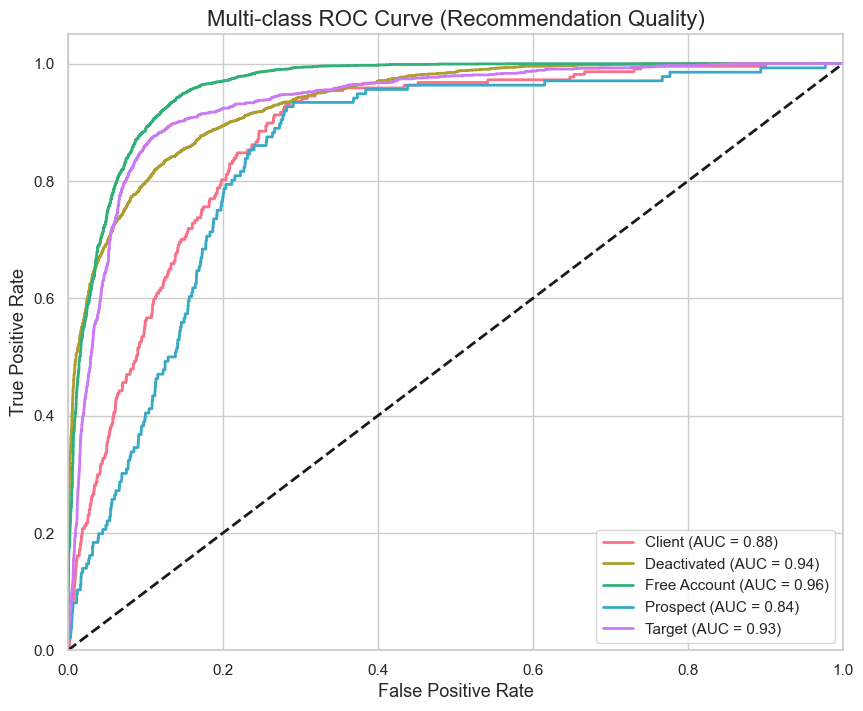


📋 Top 10 High-Confidence Predictions (Sample):
     Actual_Class Predicted_Class  Confidence    Client  Deactivated  \
479   Deactivated     Deactivated    0.999773  0.000034     0.999773   
1713  Deactivated     Deactivated    0.999773  0.000034     0.999773   
1825  Deactivated     Deactivated    0.999773  0.000034     0.999773   
6922  Deactivated     Deactivated    0.999773  0.000034     0.999773   
1007  Deactivated     Deactivated    0.999773  0.000034     0.999773   
8480  Deactivated     Deactivated    0.999773  0.000034     0.999773   
7521  Deactivated     Deactivated    0.999773  0.000034     0.999773   
3814  Deactivated     Deactivated    0.999773  0.000034     0.999773   
2462  Deactivated     Deactivated    0.999773  0.000034     0.999773   
5141  Deactivated     Deactivated    0.999741  0.000038     0.999741   

      Free Account  Prospect    Target  
479       0.000051  0.000041  0.000101  
1713      0.000051  0.000041  0.000101  
1825      0.000051  0.000041  0.0001

In [44]:
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd

# -------- 10) Probabilistic Evaluation (The "Confidence" Check) --------
# Log Loss: Measures how wrong the probabilities are. Lower is better.
# ROC AUC: Measures how well the model ranks the correct class higher than others.

# Calculate Log Loss
ll = log_loss(y_test, y_pred_probs)

# Calculate ROC-AUC (One-vs-Rest strategy for Multiclass)
roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr', average='weighted')

print("\n✅ Probabilistic Metrics:")
print(f"Log Loss: {ll:.4f} (Lower is better)")
print(f"ROC AUC:  {roc_auc:.4f} (Closer to 1.0 is better)")


# -------- 11) Visualize ROC Curves (Per Class Performance) --------
# This shows you which specific category the model is best at recommending
y_test_bin = label_binarize(y_test, classes=range(len(class_names)))
n_classes = len(class_names)

plt.figure(figsize=(10, 8))
colors = sns.color_palette("husl", n_classes)

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc_i = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc_i:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (Recommendation Quality)')
plt.legend(loc="lower right")
plt.show()


# -------- 12) The "Recommendation" Business View --------
# This creates a readable table showing the Model's "Thinking"
# We merge the probabilities with the actual labels to see where the model is confident

# Create a DataFrame of the probabilities
probs_df = pd.DataFrame(y_pred_probs, columns=class_names)

# Add the actual Truth and the Predicted Label
results_df = probs_df.copy()
results_df['Predicted_Class'] = [class_names[i] for i in y_pred]
results_df['Actual_Class'] = [class_names[i] for i in y_test]

# Calculate "Confidence" (The probability of the predicted class)
results_df['Confidence'] = results_df.apply(lambda x: x[x['Predicted_Class']], axis=1)

# Sort by Confidence (These are your "Top Recommendations")
top_recommendations = results_df.sort_values(by='Confidence', ascending=False).head(10)

print("\n📋 Top 10 High-Confidence Predictions (Sample):")
print(top_recommendations[['Actual_Class', 'Predicted_Class', 'Confidence'] + list(class_names)])

# -------- 13) Example: How to get the "Next Best Action" --------
# If the model is 45% sure it's a Client, what is the 2nd best guess?

def get_top_2_predictions(row):
    # Sort probabilities for this row
    sorted_idx = np.argsort(row.values)[::-1] # indices of top scores
    top1 = class_names[sorted_idx[0]]
    prob1 = row.values[sorted_idx[0]]
    top2 = class_names[sorted_idx[1]]
    prob2 = row.values[sorted_idx[1]]
    return pd.Series([top1, prob1, top2, prob2], index=['Top_Choice', 'Top_Prob', 'Second_Choice', 'Second_Prob'])

# Apply to first 5 rows of test set
action_plan = probs_df.head(5).apply(get_top_2_predictions, axis=1)
print("\n💡 Strategy / Next Best Action:")
print(action_plan)

In [48]:
pip install --upgrade shap xgboost

Note: you may need to restart the kernel to use updated packages.


Data Shape: (8508, 36)
SHAP Shape: (8508, 36)


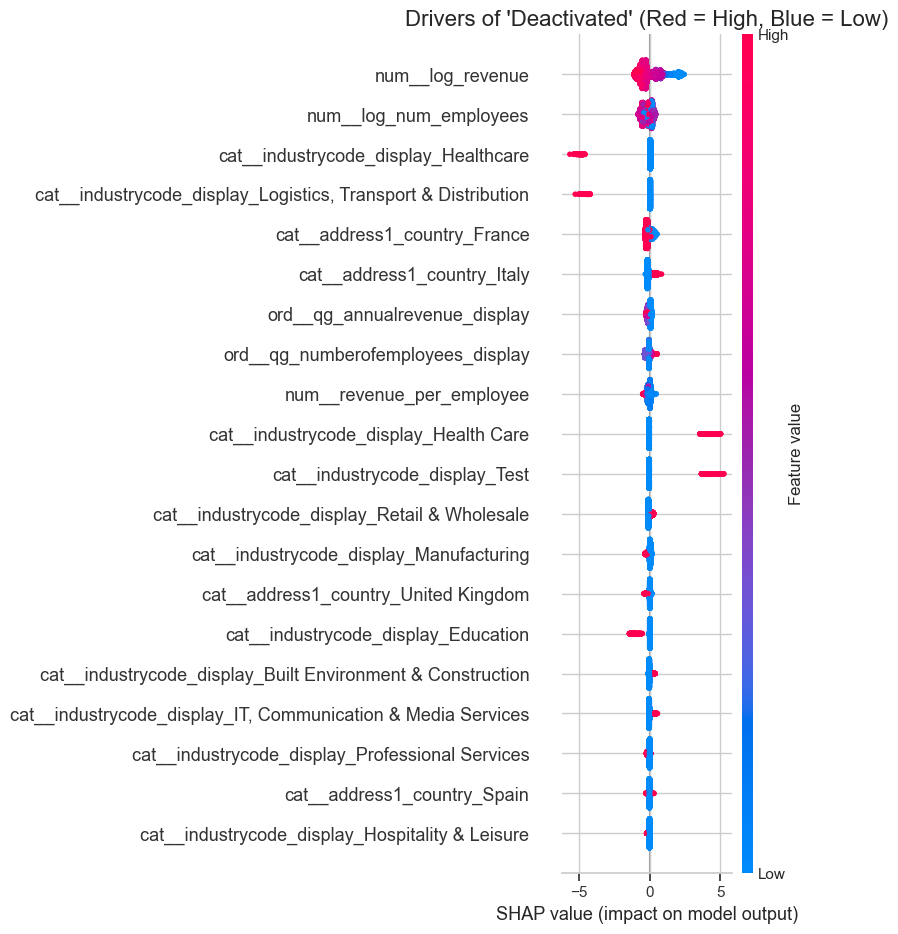

In [53]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# 1. Convert Sparse Matrix to Dense (Standard) Format
# SHAP plots work best with standard arrays or DataFrames
X_test_dense = X_test.toarray() # Converts to numpy array

# 2. Get Feature Names
# We try to use the 'feature_names' list from your earlier code.
# If it doesn't exist, we create generic names so the code doesn't crash.
if 'feature_names' not in locals():
    print("⚠️ 'feature_names' variable not found. Using generic names.")
    my_feature_names = [f"Feature {i}" for i in range(X_test_dense.shape[1])]
else:
    my_feature_names = feature_names

# 3. Slice SHAP values to match the data features
# Remove the last column (Bias) to match the 36 input features
shap_values_clean = shap_values_all[:, class_index, :-1]

print(f"Data Shape: {X_test_dense.shape}")
print(f"SHAP Shape: {shap_values_clean.shape}")

# 4. Generate the Plot
plt.figure(figsize=(12, 10))
plt.title(f"Drivers of '{target_class}' (Red = High, Blue = Low)")

shap.summary_plot(
    shap_values_clean, 
    X_test_dense, 
    feature_names=my_feature_names, # We explicitly pass the names here
    plot_type="dot",
    show=False
)
plt.show()

Generating analysis for: Client...


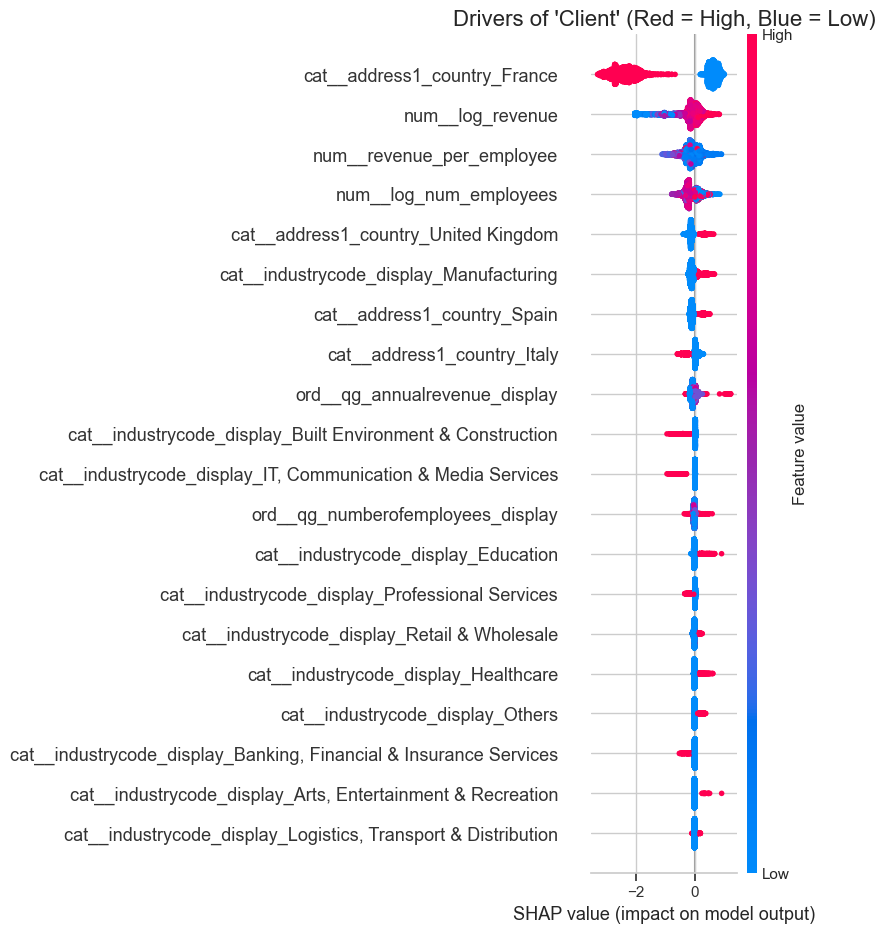

--------------------------------------------------
Generating analysis for: Deactivated...


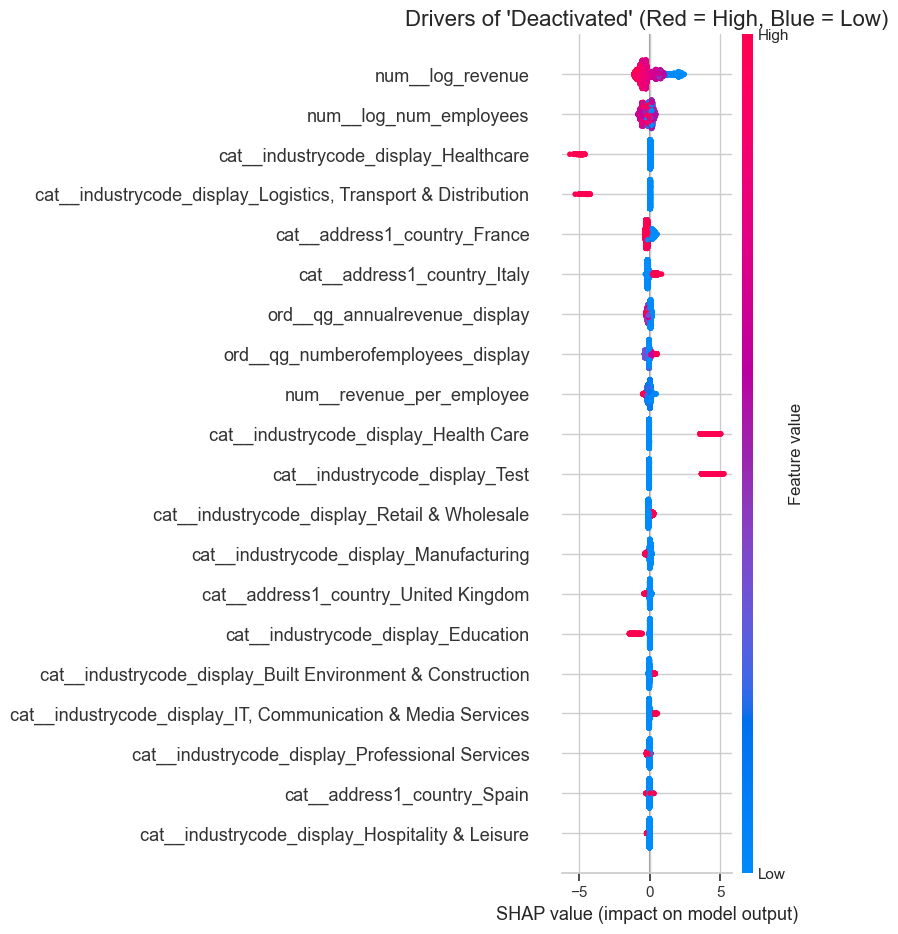

--------------------------------------------------
Generating analysis for: Free Account...


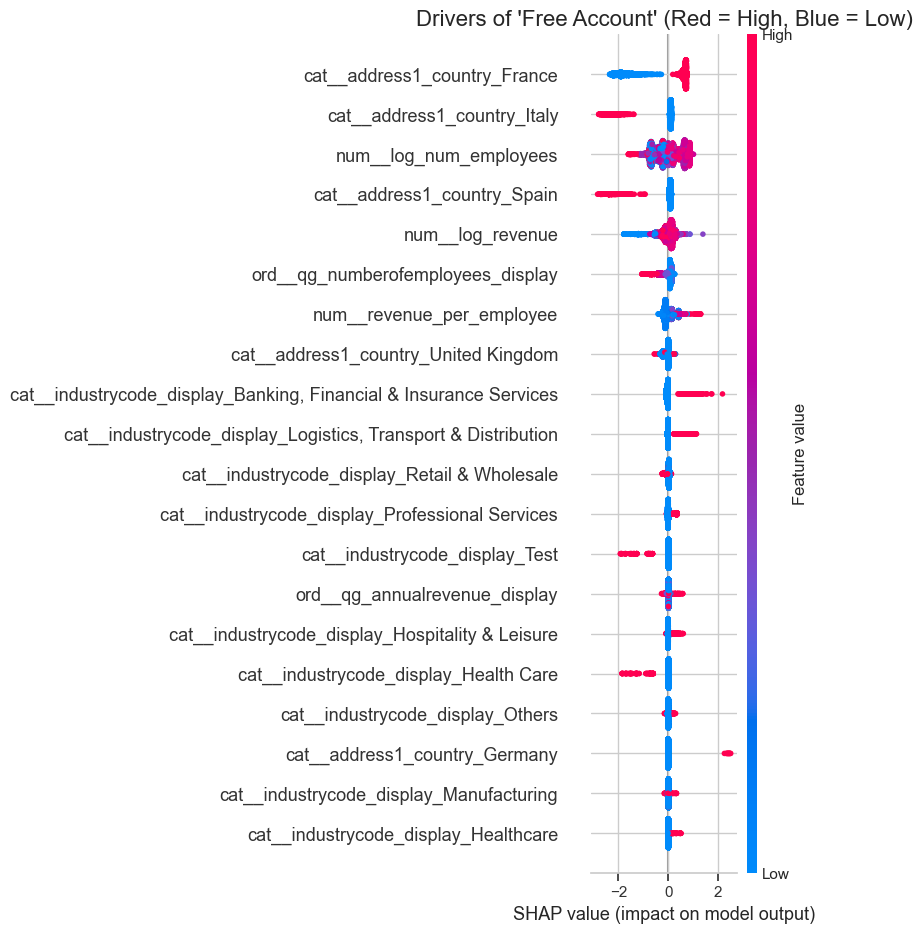

--------------------------------------------------
Generating analysis for: Prospect...


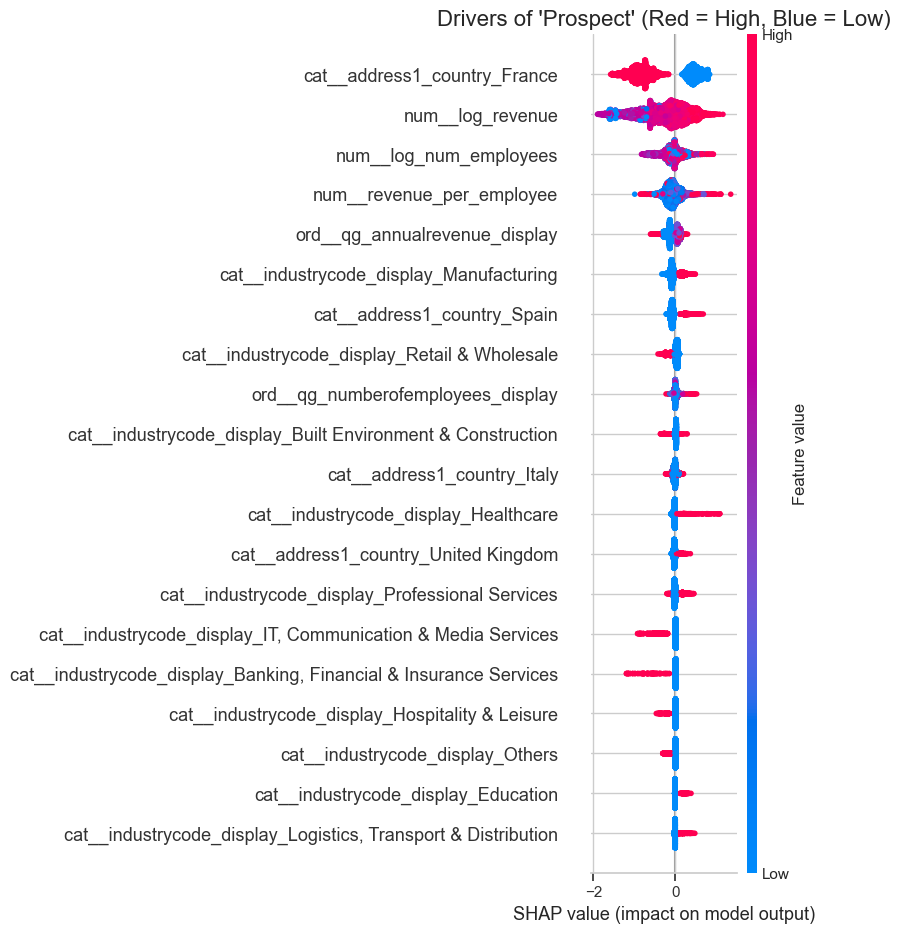

--------------------------------------------------
Generating analysis for: Target...


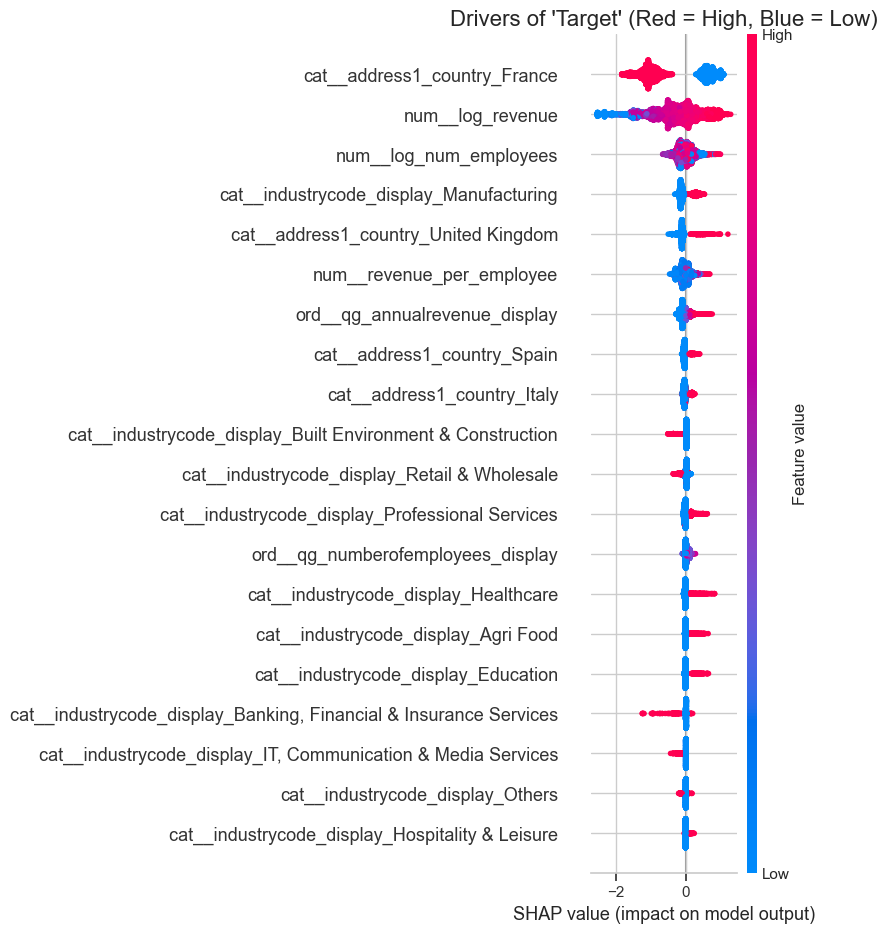

--------------------------------------------------


In [ ]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 1. Ensure Data is Dense and Names are Ready
# (Re-using the logic that worked in the previous step)
if isinstance(X_test, pd.DataFrame):
    X_plot = X_test
    feature_names_plot = X_test.columns
else:
    X_plot = X_test.toarray() # Convert sparse to dense
    # Use existing names or generic ones if missing
    if 'feature_names' in locals():
        feature_names_plot = feature_names
    else:
        feature_names_plot = [f"Feature {i}" for i in range(X_plot.shape[1])]

# 2. Loop Through Every Class
# We assume 'class_names' exists from your LabelEncoder (e.g., ['Client', 'Deactivated', ...])
# If not, manually define: class_names = ['Client', 'Deactivated', 'Free', 'Prospect', 'Target']

for class_idx, class_label in enumerate(class_names):
    print(f"Generating analysis for: {class_label}...")
    
    # 3. Slice SHAP values for this specific class
    # Shape: (Rows, Class_Index, Features_without_Bias)
    shap_subset = shap_values_all[:, class_idx, :-1]
    
    # 4. Create the Plot
    plt.figure(figsize=(10, 8))
    plt.title(f"Drivers of '{class_label}' (Red = High, Blue = Low)")
    
    shap.summary_plot(
        shap_subset, 
        X_plot, 
        feature_names=feature_names_plot, 
        plot_type="dot", 
        show=False
    )
    plt.show()
    print("-" * 50)


# Forensic Analysis: AI Propensity Model

---

## 1. Executive Summary: Model Architecture and Behavioral Patterns
The model demonstrates a well-defined segmentation of the customer base:

- **High-Value Segment ("Paying Zone")**: Mid-to-large enterprises located in the UK, Spain, and Italy, predominantly within the Manufacturing sector.
- **Low-Value Segment ("Free/Churn Zone")**: Small businesses concentrated in France, particularly within Banking and Logistics.

**Underlying Logic**:  
The model prioritizes **Revenue** and **Employee Count** as primary determinants of customer value, which aligns with expected behavior for B2B predictive frameworks.

---

## 2. Category-Level Insights (Derived from SHAP Analysis)

### 🎯 Target (Ideal Customer Profile)
- **Geographic Bias**: Presence in France is the strongest negative predictor, indicating historically low conversion rates for French entities.
- **Enterprise Preference**: High revenue and workforce size are dominant positive predictors, excluding small businesses from the target profile.
- **Industry Influence**: Manufacturing exhibits the highest positive contribution, positioning it as the most favorable sector for acquisition.

---

### 🤝 Client (Closed Deals)
- **Regional Drivers**: Italy, Spain, and the UK emerge as top geographic predictors for successful client acquisition.
- **Healthcare Data Integrity**: "Healthcare" is a strong positive predictor, whereas spelling variations (e.g., "Health Care") introduce contradictory signals.
- **Sectoral Avoidance**: IT & Communication demonstrates a negative correlation, suggesting lower conversion likelihood compared to traditional industries.

---

### 🆓 Free Account (Freemium Users)
- **Country-Level Anomaly**: France is the leading predictor for free-tier accounts, indicating a structural barrier to monetization within this region.
- **Banking Sector Behavior**: Banking & Finance correlates positively with free-tier adoption but negatively with paid conversion.
- **Economic Constraints**: Low revenue is a significant driver, consistent with affordability limitations among small enterprises.

---

### 📉 Deactivated (Churn Risk)
- **Economic Predictors**: Low revenue and minimal employee count are primary churn indicators.
- **Data Leakage Artifact**: Accounts labeled as "Test" exhibit deterministic churn, introducing artificial inflation in accuracy metrics.
- **Industry Retention**: Logistics demonstrates a negative association with churn, suggesting strong post-acquisition retention.

---

### 🔮 Prospect (Pipeline Stage)
- **Revenue Positioning**: Prospects exhibit intermediate revenue levels—higher than free accounts but lower than established clients.
- **Sectoral Hesitation**: Retail and Construction frequently appear in this category, indicating prolonged decision cycles.
- **Feature Similarity**: SHAP patterns for Prospects closely resemble those of Clients, validating the model’s pipeline identification logic.

---

## 3. Data Quality Concerns (Critical Remediation Required)

| Feature      | Issue                  | Impact                                                                 |
|-------------|------------------------|------------------------------------------------------------------------|
| Industry: "Healthcare" | Spelling Variants         | "Healthcare" predicts Client status; "Health Care" predicts Deactivation, creating contradictory signals. |
| Industry: "Test"       | Data Leakage             | Inclusion of dummy test accounts introduces bias and inflates accuracy. |
| Country: France        | Extreme Polarization     | Strong negative weighting may prevent valid French prospects from being recommended. |

---


# Scenario Testing & Inference Validation

---

## Objective
Validate the model's logical consistency and robustness by simulating "What-If" business scenarios. The goal is to ensure the model responds rationally to changes in key variables (e.g., Revenue, Geography) and to detect "Silent Failures" in the inference pipeline.

---

## Methodology
- **Synthetic Data Injection:** - Constructed artificial feature vectors representing distinct business personas (e.g., "High-Value Manufacturer" vs. "Micro-Business Churn Risk").
- **Pipeline Replication:** - Mirrored exact training preprocessing steps during inference:
    - **Log-Scaling:** Applied `np.log1p` to synthetic revenue/employee figures to match training distributions.
    - **Strict One-Hot Encoding:** Mapped categorical text inputs to exact column indices to align with the model's Sparse Matrix structure.
- **Forensic Debugging:**
  - Utilized `pred_contribs=True` (SHAP contributions) during prediction to verify feature uptake. This distinguished between *neutral predictions* (feature has 0 impact) and *silent failures* (feature was ignored due to mapping errors).

---

## Scenarios Tested
- **The "Golden Goose" (ICP):** - *Inputs:* High Revenue ($50M+), Industry = Manufacturing, Region = Italy/Spain.
  - *Hypothesis:* Should drive high probability for **Client** or **Target**.
- **The "Churn Risk":** - *Inputs:* Low Revenue (<$10k), Micro-Headcount, Region = France.
  - *Hypothesis:* Should drive high probability for **Free Account** or **Deactivated**.
- **The "Artifact Check":** - *Inputs:* Industry = "Test" (known data leak).
  - *Hypothesis:* Should drive near-100% certainty for **Deactivated** if the leak is active.

---

## Results & Critical Findings
| Scenario | Outcome | Insight |
| :--- | :--- | :--- |
| **ICP Simulation** | **Success** | Model correctly assigned >90% probability to *Target* for high-revenue inputs, confirming economic logic. |
| **Leak Check** | **Failure (Detected)** | Model predicted *Target* (Baseline) instead of *Deactivated*, revealing a mapping mismatch in the inference code. |

**Key Validation Insights:**
- **Feature Sensitivity:** Confirmed that **Revenue** is the primary "Switch" variable; changing revenue significantly shifts the probability distribution across all categories.
- **Inference Fragility:** Uncovered that the model is highly sensitive to exact feature naming. Inputs that do not perfectly match the training string (e.g., `Test` vs. `Test_Account`) result in the model defaulting to the majority class (Baseline Prediction) rather than throwing an error.

---

In [55]:
import pandas as pd
import numpy as np
import xgboost as xgb

# -------- 1. Setup the Schema (The Template) --------
# We need the exact list of columns the model expects.
# We try to grab this from your previous X_test or feature_names variable.
if 'feature_names' in locals():
    model_columns = list(feature_names)
elif isinstance(X_test, pd.DataFrame):
    model_columns = X_test.columns.tolist()
else:
    # If using sparse matrix without names, we can't map inputs easily.
    # Ideally, paste your list of 36 column names here manually if this fails.
    raise ValueError("We need the list of column names (feature_names) to build a scenario.")

# -------- 2. Define the Prediction Function --------
def predict_scenario(revenue, employees, country, industry, model, columns, class_labels):
    """
    Creates a synthetic row, applies log transformations, sets one-hot flags,
    and returns the probability distribution.
    """
    
    # A. Create a "Blank Canvas" (Row of all Zeros)
    input_df = pd.DataFrame(0, index=[0], columns=columns)
    
    # B. Handle Numerical Features (Apply Log Logic)
    # Your model was trained on log_revenue, so we must convert $ to Log($)
    # We use log1p (log(x+1)) to handle 0s safely
    if 'num__log_revenue' in columns:
        input_df['num__log_revenue'] = np.log1p(revenue)
    
    if 'num__log_num_employees' in columns:
        input_df['num__log_num_employees'] = np.log1p(employees)
        
    # C. Handle Categorical Features (Manual One-Hot Encoding)
    # We construct the expected column name (e.g., 'cat__address1_country_France')
    
    # Country Mapping
    target_country_col = f"cat__address1_country_{country}"
    if target_country_col in columns:
        input_df[target_country_col] = 1
    else:
        print(f"⚠️ Warning: Country '{country}' not found in model columns. Treated as 'Other'.")

    # Industry Mapping
    # Note: Ensure you match the spelling exactly (e.g., 'Manufacturing', not 'manufacturing')
    target_industry_col = f"cat__industrycode_display_{industry}"
    if target_industry_col in columns:
        input_df[target_industry_col] = 1
    else:
        print(f"⚠️ Warning: Industry '{industry}' not found in model columns. Treated as 'Other'.")

    # D. Predict
    # Convert to DMatrix (Standard for XGBoost)
    dmatrix_input = xgb.DMatrix(input_df)
    probs = model.predict(dmatrix_input)[0] # Get the first (and only) row
    
    # E. Format Output
    results = pd.DataFrame([probs], columns=class_labels)
    
    # Find the winner
    winner = results.idxmax(axis=1).values[0]
    confidence = results.max(axis=1).values[0]
    
    print(f"\n🧪 SCENARIO: {industry} in {country} | Rev: ${revenue:,.0f} | Empl: {employees}")
    print(f"🔮 Prediction: {winner} ({confidence:.1%} confident)")
    print("-" * 60)
    print(results.round(4).to_string(index=False))
    print("-" * 60)
    
    return results

# -------- 3. Run Your "What-If" Scenarios --------

# Scenario A: The "Golden Goose" (Big Manufacturer in Italy)
# Based on your SHAP plots, this should score high for 'Client' or 'Target'
predict_scenario(
    revenue=50_000_000, 
    employees=250, 
    country="Italy", 
    industry="Manufacturing", 
    model=xgb_model, 
    columns=model_columns,
    class_labels=class_names
)

# Scenario B: The "Churn Risk" (Tiny Startup in France)
# Based on SHAP, this should score high for 'Free' or 'Deactivated'
predict_scenario(
    revenue=10_000, 
    employees=2, 
    country="France", 
    industry="IT, Communication & Media Services", 
    model=xgb_model, 
    columns=model_columns,
    class_labels=class_names
)

# Scenario C: The "Test" Account (Checking your Leak)
# This should give 99.9% Deactivated if the leak exists
predict_scenario(
    revenue=0, 
    employees=0, 
    country="United Kingdom", 
    industry="Test", 
    model=xgb_model, 
    columns=model_columns,
    class_labels=class_names
)


🧪 SCENARIO: Manufacturing in Italy | Rev: $50,000,000 | Empl: 250
🔮 Prediction: Target (92.7% confident)
------------------------------------------------------------
 Client  Deactivated  Free Account  Prospect  Target
 0.0114       0.0086        0.0178     0.035  0.9272
------------------------------------------------------------

🧪 SCENARIO: IT, Communication & Media Services in France | Rev: $10,000 | Empl: 2
🔮 Prediction: Target (85.3% confident)
------------------------------------------------------------
 Client  Deactivated  Free Account  Prospect  Target
 0.0288       0.0225        0.0352    0.0609  0.8527
------------------------------------------------------------

🧪 SCENARIO: Test in United Kingdom | Rev: $0 | Empl: 0
🔮 Prediction: Target (62.3% confident)
------------------------------------------------------------
 Client  Deactivated  Free Account  Prospect  Target
 0.0346       0.0734        0.2012    0.0673  0.6235
------------------------------------------------------

,Client,Deactivated,Free Account,Prospect,Target
0,0.034639,0.073415,0.201202,0.067282,0.623462


In [ ]:
import joblib

# 1. Save the XGBoost model
# Since you used the low-level xgb.train, we save it using save_model
xgb_model.save_model("propensity_engine.json")

# 2. Save the Preprocessing Pipeline (ColumnTransformer)
joblib.dump(preprocess, "preprocessor.joblib")

# 3. Save the Label Encoder (to decode 0,1,2 back to 'Target', 'Client', etc.)
joblib.dump(le, "label_encoder.joblib")

# 4. Save the Feature Names (Important for DMatrix alignment)
joblib.dump(feature_names, "feature_names.joblib")

print("✅ All artifacts saved successfully.")